In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings('ignore')

In [8]:
def Heston_MCS(S, K, T, r, v, kappa, theta, lam, sigma, rho, N, M):
    
    kap = kappa + lam
    tht = kappa * theta / (kappa + lam)
        
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1, rho],
                    [rho, 1]])
    S = np.full(shape=(M, N+1), fill_value=S)
    v = np.full(shape=(M, N+1), fill_value=v)

    Z = np.random.multivariate_normal(mu, cov, (M,N))

    for i in range(1,N+1):
        S[:,i] = S[:,i-1] * np.exp((r-0.5*v[:,i-1])*dt + np.sqrt(v[:, i-1]*dt)*Z[:,i-1,0])
        v[:,i] = np.maximum(v[:,i-1] + kap*(tht-v[:,i-1])*dt + sigma*np.sqrt(v[:, i-1]*dt)*Z[:,i-1,1],0)

    pv_f = np.maximum(S[:, -1] - K, 0) * np.exp(-r*T)
    mean = np.mean(pv_f)
    error = np.std(pv_f) / np.sqrt(M)

    return mean, error

def Heston_real1 (S, K, T, r, v, kappa, theta, lam, sigma, rho, phi):

    x = np.log(S)
    u = 0.5
    a = kappa * theta
    b = kappa + lam - rho * sigma

    tmp = rho * sigma * phi * 1j


    d = np.sqrt((tmp-b)**2 - sigma**2 * (2*u*phi*1j - phi**2))
    g = (b - tmp + d) / (b - tmp - d)
    D = ((b - tmp + d) / sigma**2) * ((1-np.exp(d * T))/(1 - g * np.exp(d * T)))
    C = r * phi * 1j * T + (a/sigma**2)* ( (b - tmp + d) * T - 2 * np.log((1 - g * np.exp(d*T))/(1 -g)))

    f = np.exp(C + D * v + 1j * phi * x)

    re = np.real((np.exp(-phi * 1j * np.log(K)) * f)/(1j * phi))

    return re

def Heston_real2 (S, K, T, r, v, kappa, theta, lam, sigma, rho, phi):

    x = np.log(S)
    u = -0.5
    a = kappa * theta
    b = kappa + lam

    tmp = rho * sigma * phi * 1j

    d = np.sqrt((tmp-b)**2 - sigma**2 * (2*u*phi*1j - phi**2))
    g = (b - tmp + d) / (b - tmp - d)
    D = ((b - tmp + d) / sigma**2) * ((1-np.exp(d * T))/(1 - g * np.exp(d * T)))
    C = r * phi * 1j * T + (a/sigma**2)* ( (b - tmp + d) * T - 2 * np.log((1 - g * np.exp(d*T))/(1 -g)))

    f = np.exp(C + D * v + 1j * phi * x)

    re = np.real((np.exp(-phi * 1j * np.log(K)) * f)/(1j * phi))

    return re    

def Heston (S, K, T, r, v, kappa, theta, lam, sigma, rho):

    phi = np.arange(0.001, 100, 0.001)

    args = (S, K, T, r, v, kappa, theta, lam, sigma, rho)

    p1 = 0.5 + 1/np.pi * np.trapz(Heston_real1(*args, phi), dx=0.001)
    p2 = 0.5 + 1/np.pi * np.trapz(Heston_real2(*args, phi), dx=0.001)

    return S * p1 - K * np.exp(-r*T)*p2


### Heston ex1

In [9]:
reg = Heston(S=100, K=100, T=30/365, r=0, v=0.01, kappa=2, theta=0.01, lam=0, sigma=0.1, rho=0)
np.round(reg, 4)

1.1345

### Heston ex2

In [10]:
reg = Heston(S=100, K=100, T=0.5, r=0.05, v=0.01, kappa=2, theta=0.01, lam=0, sigma=0.225, rho=0)
np.round(reg, 4)

4.085

### Heston ex3

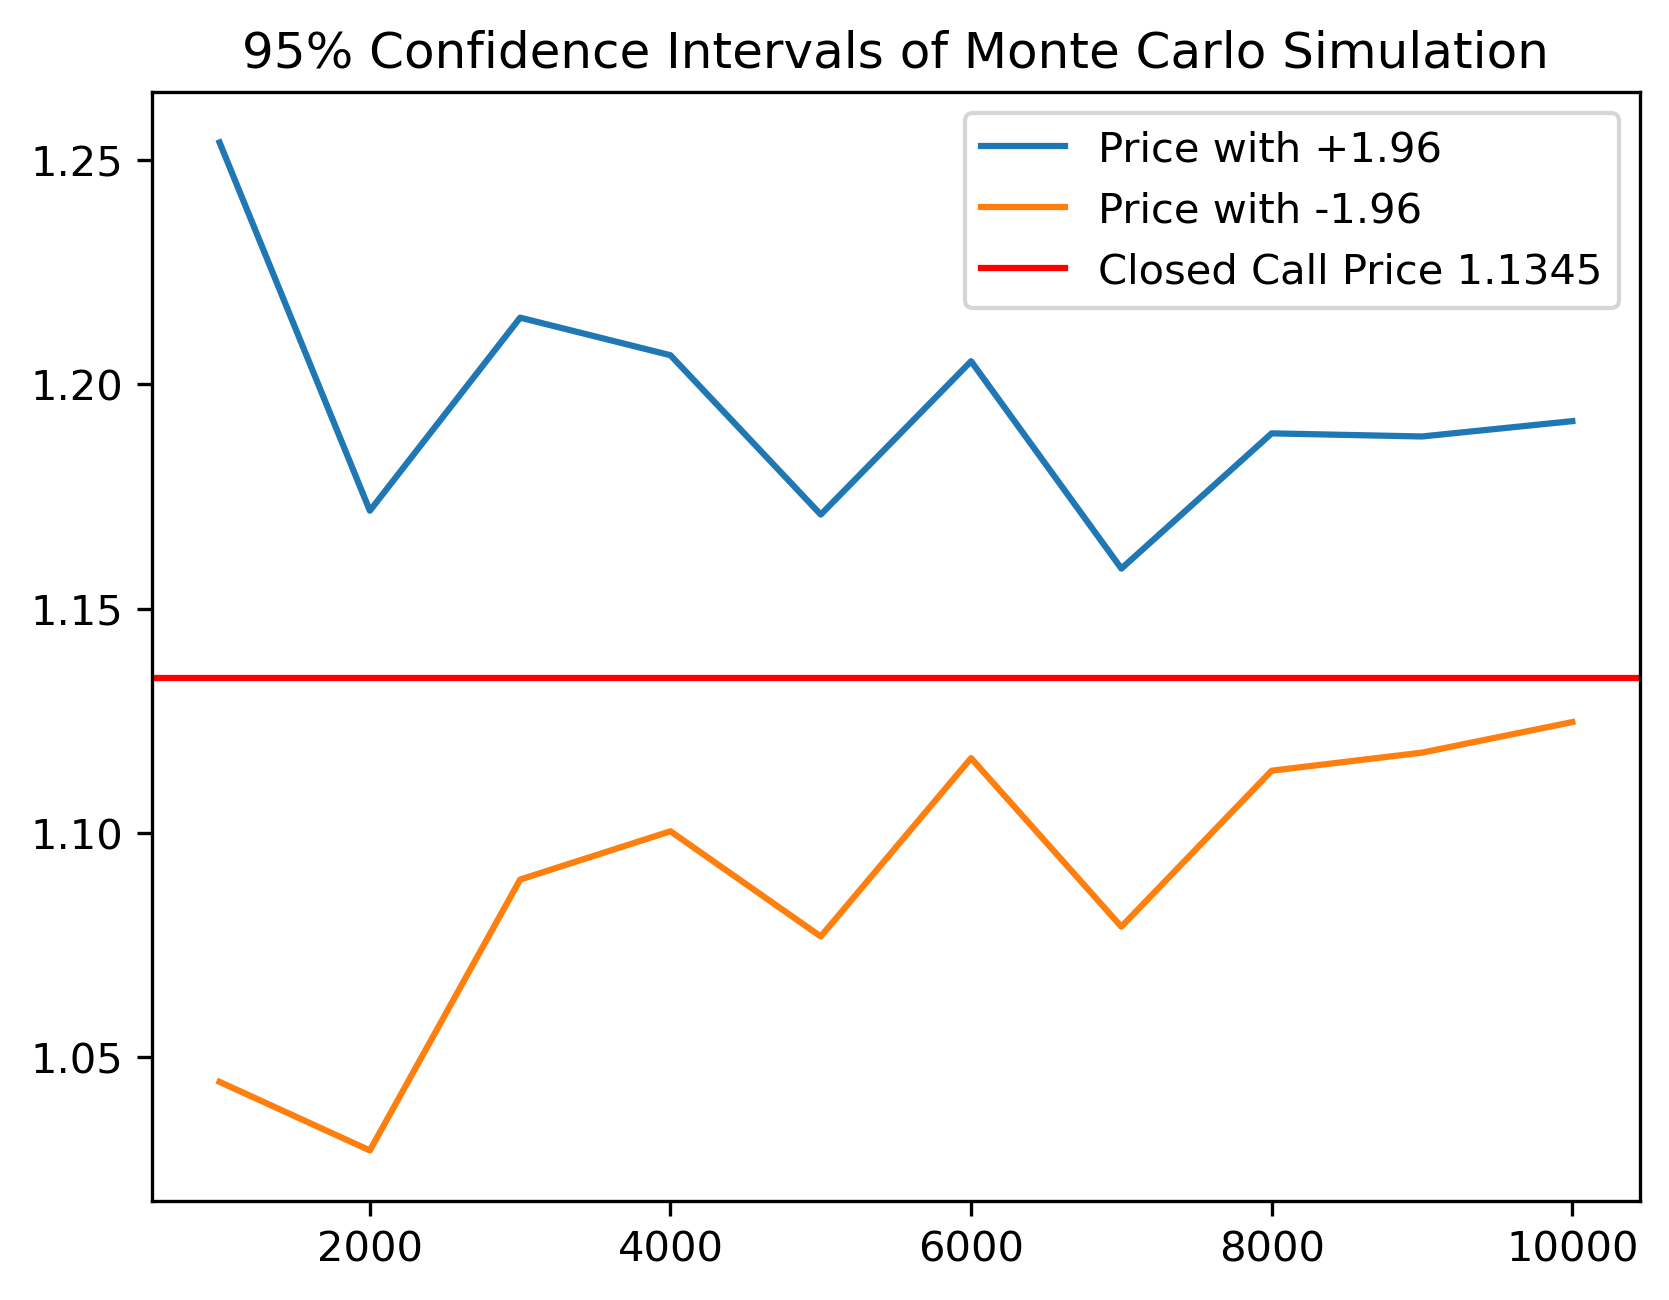

In [11]:
call_price = Heston(S=100, K=100, T=30/365, r=0, v=0.01, kappa=2, theta=0.01, lam=0, sigma=0.1, rho=0)

reg_df = pd.DataFrame(columns=['Price_low', 'Price_high', 'Sim_Num'])

for i in range(1, 11):
    sim_num = 1000 * i
    price, error = Heston_MCS(S=100.0, K=100.0, T=30/365, r=0.0, v=0.01, kappa=2.0, theta=0.01, lam=0.0, sigma=0.1, rho=0.0, N=100, M=sim_num)
    
    price_low  = price - 1.96 * error
    price_high = price + 1.96 * error

    reg_df.loc[i,'Price_low'] = price_low
    reg_df.loc[i,'Price_high'] = price_high
    reg_df.loc[i,'Sim_Num'] = sim_num


plt.figure(dpi=300)
plt.title('95% Confidence Intervals of Monte Carlo Simulation')
plt.plot(reg_df['Sim_Num'], reg_df['Price_high'], label='Price with +1.96')
plt.plot(reg_df['Sim_Num'], reg_df['Price_low'], label='Price with -1.96')
plt.axhline(call_price, color='r', label=f'Closed Call Price {np.round(call_price, 4)}')
plt.legend()
plt.show()